In [1]:
# Read file data/experiments.xlsx
import pandas as pd

SHEET_ID = "1aqVHlqcHHhNzRPfGKa8Ppt4wnDS-SGnl9ekOK7qblrE"

# Online connect to google spreadsheet
url = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv"

df_header = pd.read_csv(url, nrows=200, header=1)
df_no_header = pd.read_csv(url, header=None, skiprows=200)



## Experimente Entwicklung

In [24]:
# Werte für Trichterdiagramm extrahieren
experiments_count = int(df_no_header.iloc[35][1])
cc1 = int(df_no_header.iloc[36][1])
below10k = int(df_no_header.iloc[37][1])
labels = ["Number of experiments", "Positive Consistency Check #1", "Less than 10.000 calls"]
values = [experiments_count, cc1, below10k]

import plotly.graph_objects as go
palette = ["#006D77", "#83C5BE", "#EDF6F9"]
fig = go.Figure(go.Funnel(
    y=labels,
    x=values,
    textinfo="value+percent previous",
    texttemplate="%{label}<br><b>%{value:,}</b><br>%{percentPrevious:.1%}",
    marker={"color": palette},
    opacity=0.9
) )
fig.update_layout(
    plot_bgcolor="#FFFFFF",
    paper_bgcolor="#FFFFFF",
    font={"family": "IBM Plex Sans", "color": "#1F2937"},
    margin={"l": 80, "r": 40, "t": 80, "b": 40},
    yaxis={"showticklabels": False}
)
fig.update_traces(hovertemplate="<b>%{label}</b><br>%{value:,} (%{percentPrevious:.1%})<extra></extra>")
fig.show()

# Korrelationsmatrizen

- Calls vs. Methoden vs. Klassen

In [25]:
# Get columns "Calls", "DISTINCT methods" and "DISTINCT classes" from df_header and remove NaN rows
calls = df_header['Calls'].dropna().astype(int).tolist()
distinct_methods = df_header['DISTINCT methods'].dropna().astype(int).tolist()
distinct_classes = df_header['DISTINCT classes'].dropna().astype(int).tolist()

# Check if all lists have the same length
if not (len(calls) == len(distinct_methods) == len(distinct_classes)):
    raise ValueError("Columns 'Calls', 'DISTINCT methods' and 'DISTINCT classes' must have the same number of non-NaN entries.")

# Caluclate correlation matrix 
data = {
    'Calls': calls,
    'DISTINCT methods': distinct_methods,
    'DISTINCT classes': distinct_classes
}
df_corr = pd.DataFrame(data)
corr_matrix = df_corr.corr()

# Visualize correlation matrix with plotly
import plotly.express as px
fig_corr = px.imshow(
    corr_matrix,
    text_auto=".2f",
    color_continuous_scale='RdBu_r',
    zmin=-1,
    zmax=1,
    title="Correlation Matrix"
)
fig_corr.show()

# Methoden vs. Klassen


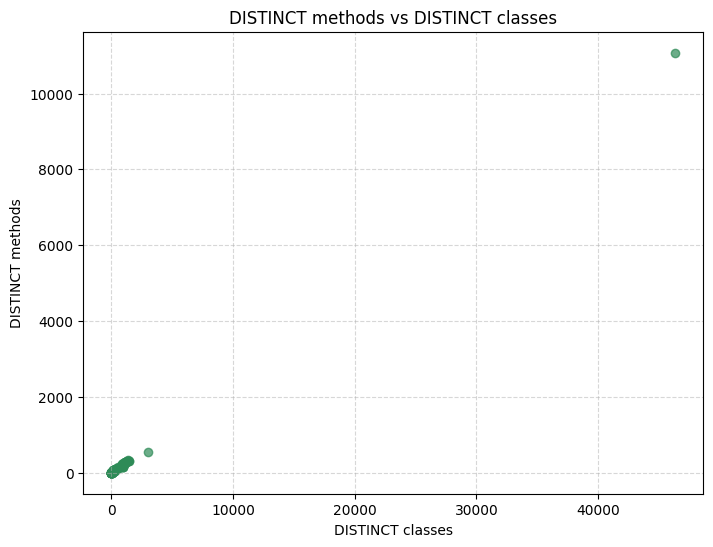

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Extract 2-tuples of (DISTINCT methods, DISTINCT classes)
tuples_2d = []
for index, row in df_header.iterrows():
    distinct_methods = row['DISTINCT methods']
    distinct_classes = row['DISTINCT classes']
    if pd.notna(distinct_methods) and pd.notna(distinct_classes):
        tuple_2d = (
            distinct_methods,
            distinct_classes
        )
        tuples_2d.append(tuple_2d)

# Visualize DISTINCT methods vs DISTINCT classes using matplotlib

def plot_pair(ax, x, y, marker, color, title):
    ax.scatter(x, y, marker=marker, color=color, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("DISTINCT methods" if "Method" in title else "DISTINCT classes")
    ax.set_ylabel("DISTINCT classes" if "Method" in title else "DISTINCT methods")
    ax.grid(True, linestyle='--', alpha=0.5)
method_color = "#FF6F61"
class_color = "#6B5B95"
x_methods = [t[0] for t in tuples_2d]
y_classes = [t[1] for t in tuples_2d]
fig, ax = plt.subplots(figsize=(8, 6))
plot_pair(ax, x_methods, y_classes, "o", "#2E8B57", "DISTINCT methods vs DISTINCT classes")
plt.show()


In [ ]:
# Alle relevanten Spalten numerisch konvertieren
df_header["Calls"] = pd.to_numeric(df_header["Calls"], errors="coerce")
df_header["DISTINCT classes"] = pd.to_numeric(df_header["DISTINCT classes"], errors="coerce")
df_header["DISTINCT methods"] = pd.to_numeric(df_header["DISTINCT methods"], errors="coerce")

# Daten filtern und NaNs entfernen
df_filtered = df_header.dropna(subset=["Calls", "DISTINCT classes", "DISTINCT methods"])

# Über alle calls hinweg Korrelationen berechnen
df_general = df_filtered[df_filtered["Calls"] > 0]

# Unter 10.000
df_below_10k = df_filtered[df_filtered["Calls"] < 10000]

# Über 10.000 
df_above_10k = df_filtered[df_filtered["Calls"] >= 10000]

# Unter 50.000
df_below_50k = df_filtered[df_filtered["Calls"] < 50000]

# Ab 50.000 und mehr
df_above_50k = df_filtered[df_filtered["Calls"] >= 50000]

# Korrelationen berechnen
corr_general = df_general[["Calls", "DISTINCT classes", "DISTINCT methods"]].corr()
corr_below_10k = df_below_10k[["Calls", "DISTINCT classes", "DISTINCT methods"]].corr()
corr_above_10k = df_above_10k[["Calls", "DISTINCT classes", "DISTINCT methods"]].corr()
corr_below = df_below_50k[["Calls", "DISTINCT classes", "DISTINCT methods"]].corr()
corr_above = df_above_50k[["Calls", "DISTINCT classes", "DISTINCT methods"]].corr()

#print("Korrelationen für Calls < 50.000:")
#print(corr_below)
#print("\nKorrelationen für Calls >= 50.000:")
#print(corr_above)
print("\nKorrelationen für Calls < 10.000:")
print(corr_below_10k)
print("\nKorrelationen für Calls >= 10.000:")
print(corr_above_10k)
print("\nKorrelationen für alle Calls:")
print(corr_general)


# Visualize quality (results) vs. all

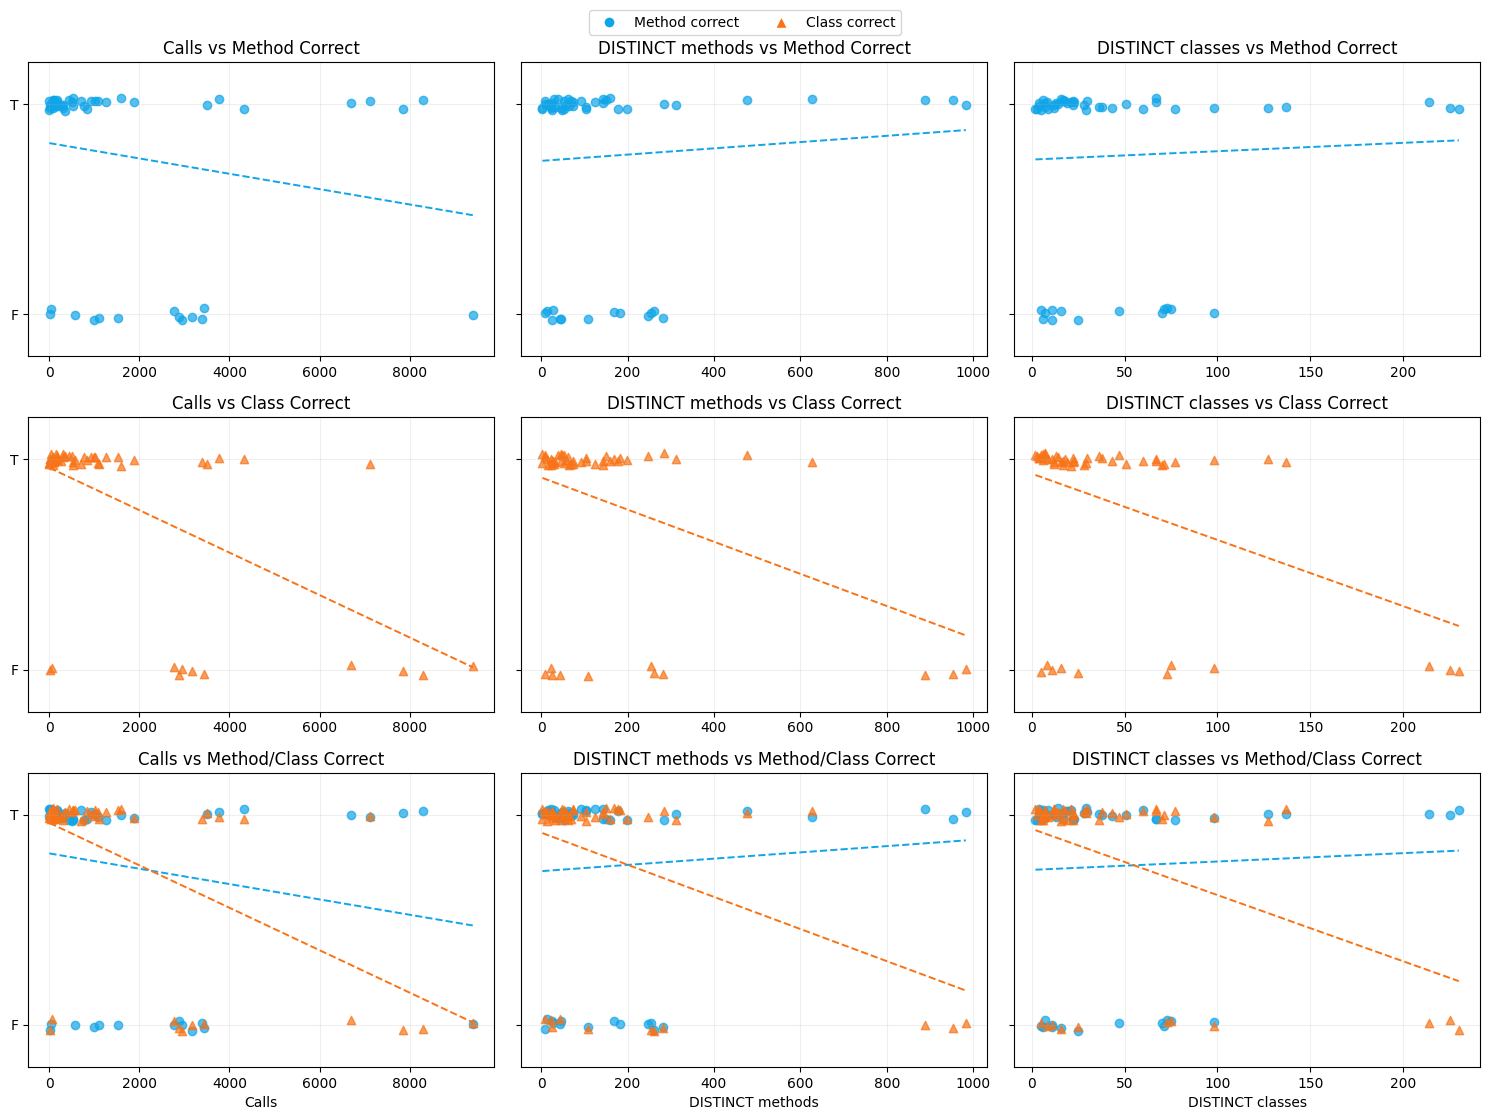

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Extract tuples: (Calls, DISTINCT methods, DISTINCT classes, Class correct, Method correct)
tuples_5d = []
for _, row in df_header.iterrows():
    if pd.notna(row['Calls']) and pd.notna(row['DISTINCT methods']) and pd.notna(row['DISTINCT classes']) and pd.notna(row['Class correct']) and pd.notna(row['Method correct']):
        tuples_5d.append(
            (
                int(row['Calls']),
                int(row['DISTINCT methods']),
                int(row['DISTINCT classes']),
                str(row['Class correct']).strip().upper() == "T",
                str(row['Method correct']).strip().upper() == "T",
            )
        )

def plot_pair(ax, x_vals, y_vals, marker, color, label):
    if len(x_vals) == 0:
        return
    jitter = rng.uniform(-0.03, 0.03, size=len(x_vals))
    ax.scatter(x_vals, y_vals + jitter, marker=marker, color=color, alpha=0.7)
    if len(x_vals) >= 2 and y_vals.sum() not in (0, len(y_vals)):
        coeffs = np.polyfit(x_vals, y_vals, 1)
        x_line = np.linspace(x_vals.min(), x_vals.max(), 50)
        ax.plot(x_line, coeffs[0] * x_line + coeffs[1], color=color, linestyle="--", linewidth=1.4)
    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["F", "T"])
    ax.grid(alpha=0.2)
    ax.set_title(label)

# Multigrid: Method, Class, Overlay für jede Metrik (3x3)
if tuples_5d:
    arr = np.array(tuples_5d, dtype=object)
    metrics = [
        ("Calls", arr[:, 0].astype(int)),
        ("DISTINCT methods", arr[:, 1].astype(int)),
        ("DISTINCT classes", arr[:, 2].astype(int)),
    ]
    y_class = arr[:, 3].astype(bool).astype(int)
    y_method = arr[:, 4].astype(bool).astype(int)
    method_color, class_color = "#0ea5e9", "#f97316"
    rng = np.random.default_rng(seed=42)
    fig, axes = plt.subplots(3, 3, figsize=(15, 11), sharey=True)

    for col, (label, x_vals) in enumerate(metrics):
        plot_pair(axes[0, col], x_vals, y_method, "o", method_color, f"{label} vs Method Correct")
        plot_pair(axes[1, col], x_vals, y_class, "^", class_color, f"{label} vs Class Correct")
        ax_o = axes[2, col]
        plot_pair(ax_o, x_vals, y_method, "o", method_color, f"{label} vs Overlay")
        plot_pair(ax_o, x_vals, y_class, "^", class_color, f"{label} vs Overlay")
        ax_o.set_title(f"{label} vs Method/Class Correct")
        ax_o.set_xlabel(label)

    legend_handles = [
        Line2D([0], [0], marker="o", color="w", markerfacecolor=method_color, markersize=8, label="Method correct"),
        Line2D([0], [0], marker="^", color="w", markerfacecolor=class_color, markersize=8, label="Class correct"),
    ]
    fig.legend(handles=legend_handles, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))
    plt.tight_layout()
    plt.show()
else:
    print("Keine gültigen Daten für den Plot gefunden.")

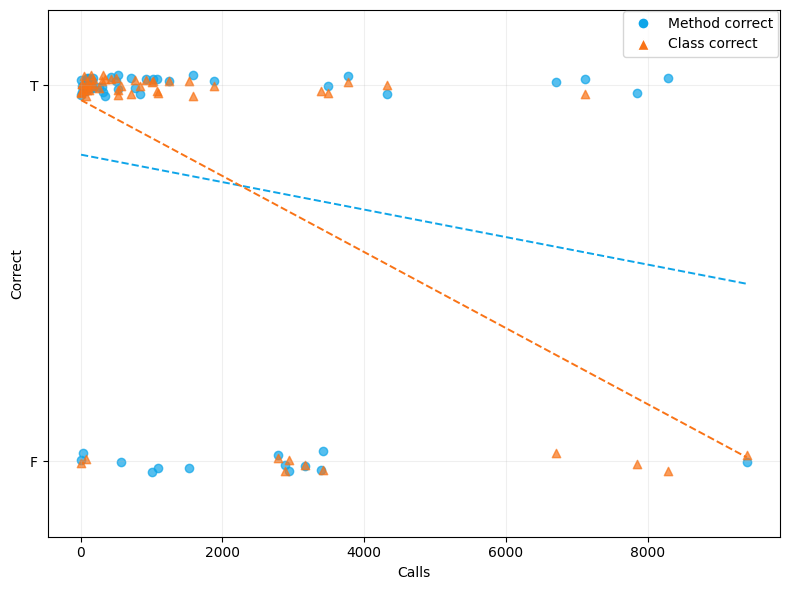

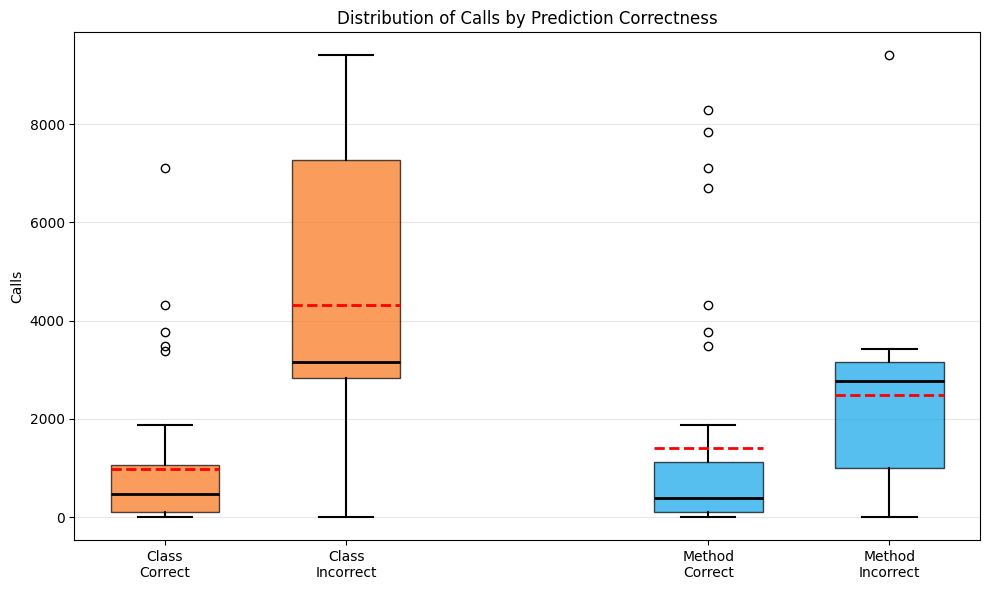

In [63]:
# Plot only Calls vs Method/Class correct
if tuples_5d:
    arr = np.array(tuples_5d, dtype=object)
    x_calls = arr[:, 0].astype(int)
    y_class = arr[:, 3].astype(bool).astype(int)
    y_method = arr[:, 4].astype(bool).astype(int)
    method_color, class_color = "#0ea5e9", "#f97316"
    rng = np.random.default_rng(seed=42)
    fig, ax = plt.subplots(figsize=(8, 6))

    plot_pair(ax, x_calls, y_method, "o", method_color, "Calls vs Method/Class Correct")
    plot_pair(ax, x_calls, y_class, "^", class_color, "Calls vs Method/Class Correct")
    ax.set_title("")#Calls vs Method/Class Correct")
    ax.set_xlabel("Calls")
    ax.set_ylabel("Correct")
    legend_handles = [
        Line2D([0], [0], marker="o", color="w", markerfacecolor=method_color, markersize=8, label="Method correct"),
        Line2D([0], [0], marker="^", color="w", markerfacecolor=class_color, markersize=8, label="Class correct"),
    ]
    fig.legend(handles=legend_handles, bbox_to_anchor=(0.988, 0.985))
    plt.tight_layout()
    plt.show()

    # Add a candle diagram showing distribution of calls for correct vs incorrect predictions
    fig, ax = plt.subplots(figsize=(10, 6))

    # Separate data by correctness
    correct_class = x_calls[y_class == 1]
    incorrect_class = x_calls[y_class == 0]
    correct_method = x_calls[y_method == 1]
    incorrect_method = x_calls[y_method == 0]

    # Create box plot data
    box_data = [correct_class, incorrect_class, correct_method, incorrect_method]
    positions = [1, 2, 4, 5]
    colors = [class_color, class_color, method_color, method_color]

    bp = ax.boxplot(box_data, positions=positions, widths=0.6, patch_artist=True,
                    showmeans=True, meanline=True,
                    boxprops=dict(alpha=0.7),
                    medianprops=dict(color='black', linewidth=2),
                    meanprops=dict(color='red', linewidth=2, linestyle='--'),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_xticks(positions)
    ax.set_xticklabels(['Class\nCorrect', 'Class\nIncorrect', 'Method\nCorrect', 'Method\nIncorrect'])
    ax.set_ylabel('Calls')
    ax.set_title('Distribution of Calls by Prediction Correctness')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

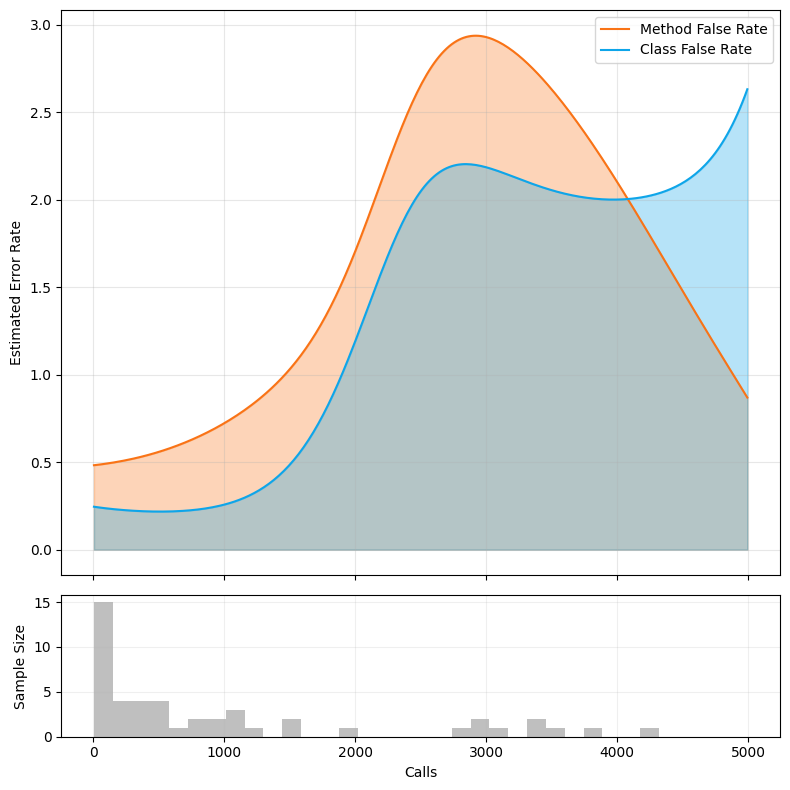

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

if tuples_5d:
    df_plot = pd.DataFrame(
        tuples_5d,
        columns=[
            "Calls",
            "DISTINCT methods",
            "DISTINCT classes",
            "Class correct",
            "Method correct",
        ],
    )

    calls_all = df_plot["Calls"].values.astype(float)
    calls_method_false = df_plot.loc[df_plot["Method correct"] == 0, "Calls"].values.astype(float)
    calls_class_false = df_plot.loc[df_plot["Class correct"] == 0, "Calls"].values.astype(float)

    # x-Achse bis maximal 5000
    x_vals_full = np.linspace(calls_all.min(), calls_all.max(), 500)
    x_vals = x_vals_full[x_vals_full <= 5000]

    kde_all = gaussian_kde(calls_all, bw_method=0.3)
    kde_method_false = gaussian_kde(calls_method_false, bw_method=0.3)
    kde_class_false = gaussian_kde(calls_class_false, bw_method=0.3)

    all_vals_full = kde_all(x_vals_full)
    method_false_vals_full = kde_method_false(x_vals_full)
    class_false_vals_full = kde_class_false(x_vals_full)

    # Nur Werte bis 5000
    all_vals = all_vals_full[x_vals_full <= 5000]
    method_false_vals = method_false_vals_full[x_vals_full <= 5000]
    class_false_vals = class_false_vals_full[x_vals_full <= 5000]

    # Fehlerquote = Fehler-Dichte / Gesamt-Dichte
    method_error_rate = np.divide(method_false_vals, all_vals, out=np.zeros_like(all_vals), where=all_vals>1e-8)
    class_error_rate = np.divide(class_false_vals, all_vals, out=np.zeros_like(all_vals), where=all_vals>1e-8)

    # Sample Size Histogram, nur bis 5000
    sample_sizes, bins = np.histogram(calls_all[calls_all <= 5000], bins=30)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios':[4,1]}, sharex=True)

    ax1.plot(x_vals, method_error_rate, color="#f97316", label="Method False Rate")
    ax1.plot(x_vals, class_error_rate, color="#0ea5e9", label="Class False Rate")
    ax1.fill_between(x_vals, 0, method_error_rate, color="#f97316", alpha=0.3)
    ax1.fill_between(x_vals, 0, class_error_rate, color="#0ea5e9", alpha=0.3)
    ax1.set_ylabel("Estimated Error Rate")
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.bar(bin_centers, sample_sizes, width=bins[1]-bins[0], color="gray", alpha=0.5)
    ax2.set_ylabel("Sample Size")
    ax2.set_xlabel("Calls")
    ax2.grid(alpha=0.2)

    plt.tight_layout()
    plt.show()

else:
    print("Keine gültigen Daten gefunden.")


# Qualität pro Projekt

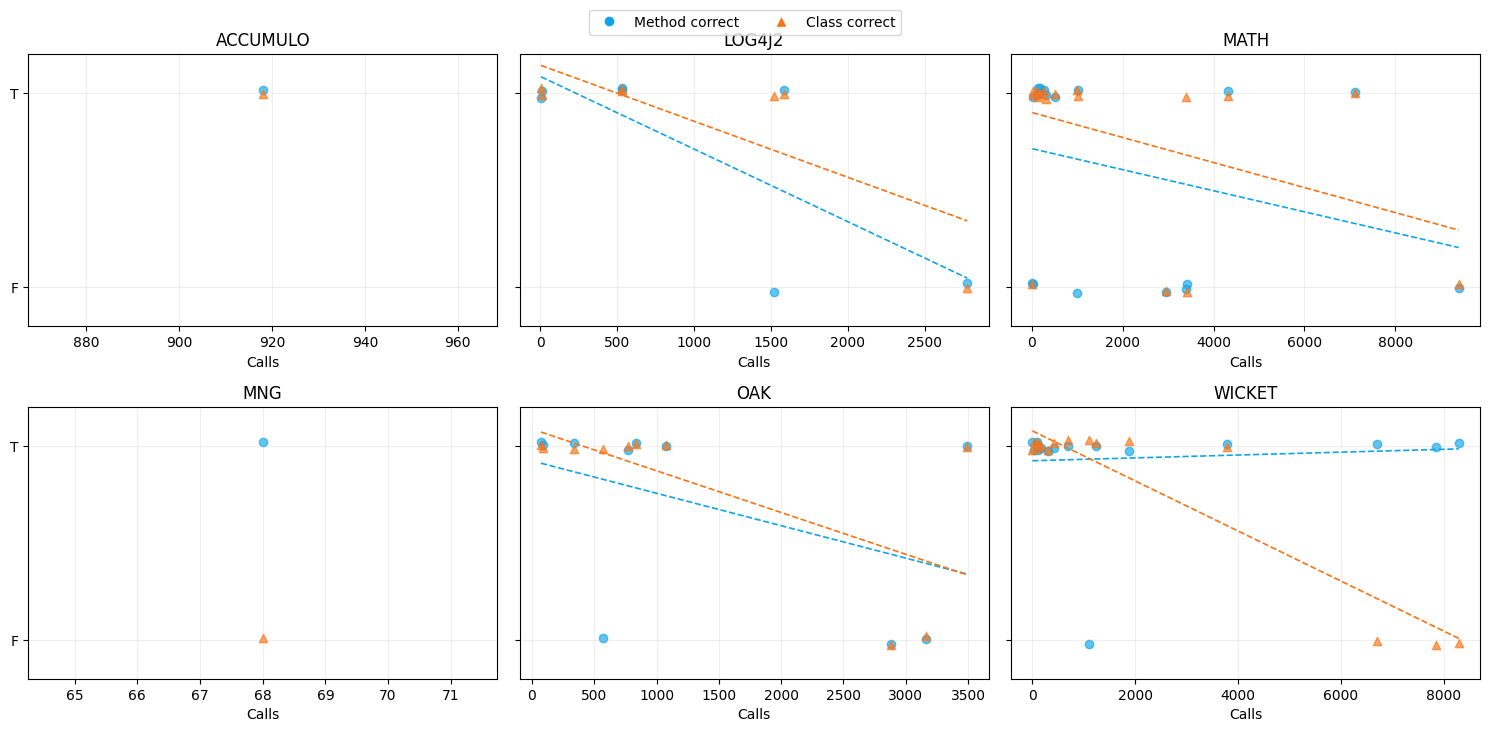

In [60]:
# Extract and plot Calls vs quality per project
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df_proj = df_header[['Projekt', 'Calls', 'Class correct', 'Method correct']].dropna().copy()
df_proj['class_bool'] = df_proj['Class correct'].astype(str).str.strip().str.upper().eq('T').astype(int)
df_proj['method_bool'] = df_proj['Method correct'].astype(str).str.strip().str.upper().eq('T').astype(int)

def add_series(ax, x, y, marker, color):
    jitter = rng.uniform(-0.03, 0.03, size=len(x))
    ax.scatter(x, y + jitter, marker=marker, color=color, alpha=0.65)
    if len(x) >= 2:
        coeffs = np.polyfit(x, y, 1)
        x_line = np.linspace(x.min(), x.max(), 50)
        ax.plot(x_line, coeffs[0] * x_line + coeffs[1], color=color, linestyle='--', linewidth=1.2)

if not df_proj.empty:
    projects = sorted(df_proj['Projekt'].unique())
    n = len(projects)
    cols = 3
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3.6 * rows), sharey=True)
    axes = np.atleast_2d(axes)
    method_color, class_color = '#0ea5e9', '#f97316'
    rng = np.random.default_rng(seed=42)

    for idx, proj in enumerate(projects):
        r, c = divmod(idx, cols)
        g = df_proj[df_proj['Projekt'] == proj]
        x = g['Calls'].astype(int).to_numpy()
        y_cls = g['class_bool'].to_numpy()
        y_mth = g['method_bool'].to_numpy()
        add_series(axes[r, c], x, y_mth, 'o', method_color)
        add_series(axes[r, c], x, y_cls, '^', class_color)
        axes[r, c].set_title(proj)
        axes[r, c].set_xlabel('Calls')
        axes[r, c].set_ylim(-0.2, 1.2)
        axes[r, c].set_yticks([0, 1])
        axes[r, c].set_yticklabels(['F', 'T'])
        axes[r, c].grid(alpha=0.2)

    for j in range(n, rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis('off')

    legend_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=method_color, markersize=8, label='Method correct'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor=class_color, markersize=8, label='Class correct'),
    ]
    fig.legend(handles=legend_handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))
    plt.tight_layout()
    plt.show()
else:
    print('Keine gültigen Daten für den Plot gefunden.')

# Distances

### LLM-Patched
This metric refers to the distance of the patched `class.method` (= target) and the LLM's predicted `class.method`. 

This metric is interesting in the case the prediction is wrong, as it shows "how far away" the LLM was from the correct answer. 

Notes:
- may include the factor of the call tree size. A distance of "1" may be good for large call trees but not so good for (much) smaller ones. => Solvable by determining the longest possible path and set this in relation to the calculated distance.

### Test-Patched
This metric refers to the distance between the patched `class.method` and the executed test `class.method` (= starting point).

This metric evaluates whether the distance has an impact on the LLM's prediction or not by computing the correlation.

### Test-LLM
This metric refers to the distance between the executed test `class.method` and the LLM's predicted `class.method`

This metric evaluates if the LLM chose (in wrong cases) more distant methods or closer methods with relation to the test method. 

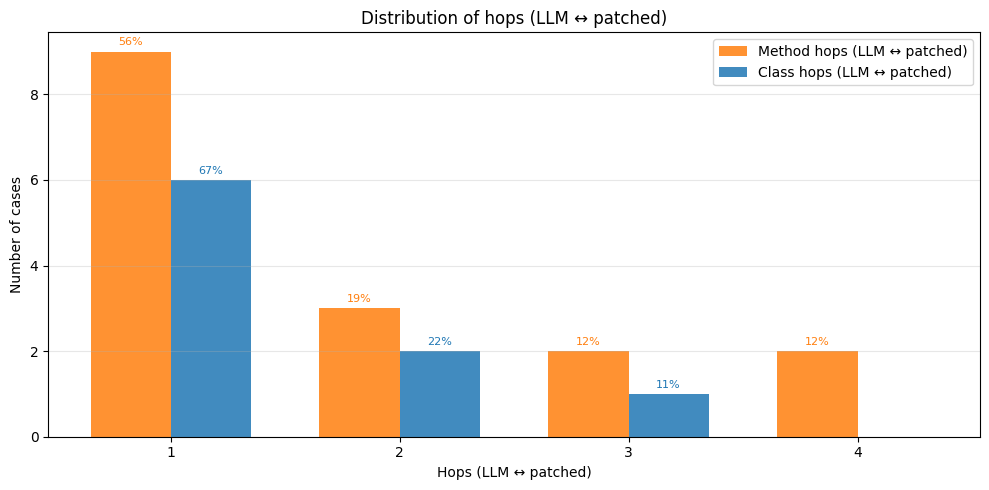

In [28]:
# Visualize LLM-Patched distances and their occurrences

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Extract Method hops (LLM <-> patched), exclude 0 and negative values
method_hops = (
    df_header['Method hops (LLM <-> patched)']
    .dropna()
    .astype(int)
    .loc[lambda s: s > 0]
    .tolist()
)

## Extract Class hops (LLM <-> patched), exclude 0 and negative values
class_hops = (
    df_header['Class Hops (LLM <-> patched)']
    .dropna()
    .astype(int)
    .loc[lambda s: s > 0]
    .tolist()
)

method_counts = pd.Series(method_hops).value_counts().sort_index()
class_counts = pd.Series(class_hops).value_counts().sort_index()

all_indices = sorted(set(method_counts.index) | set(class_counts.index))
method_vals = [method_counts.get(i, 0) for i in all_indices]
class_vals = [class_counts.get(i, 0) for i in all_indices]

method_total = sum(method_vals)
class_total = sum(class_vals)

x = np.arange(len(all_indices))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars_method = ax.bar(x - width/2, method_vals, width, color="#ff7f0e", alpha=0.85, label="Method hops (LLM ↔ patched)")
bars_class  = ax.bar(x + width/2, class_vals,  width, color="#1f77b4", alpha=0.85, label="Class hops (LLM ↔ patched)")

# Add percentage labels on top of each bar
for bar, val in zip(bars_method, method_vals):
    if val > 0:
        pct = val / method_total * 100
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1,
                f'{pct:.0f}%', ha='center', va='bottom', fontsize=8, color="#ff7f0e")

for bar, val in zip(bars_class, class_vals):
    if val > 0:
        pct = val / class_total * 100
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1,
                f'{pct:.0f}%', ha='center', va='bottom', fontsize=8, color="#1f77b4")

ax.set_xlabel("Hops (LLM ↔ patched)")
ax.set_ylabel("Number of cases")
ax.set_title("Distribution of hops (LLM ↔ patched)")
ax.set_xticks(x)
ax.set_xticklabels(all_indices)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Keep hops_counts for downstream cells
hops_counts = method_counts


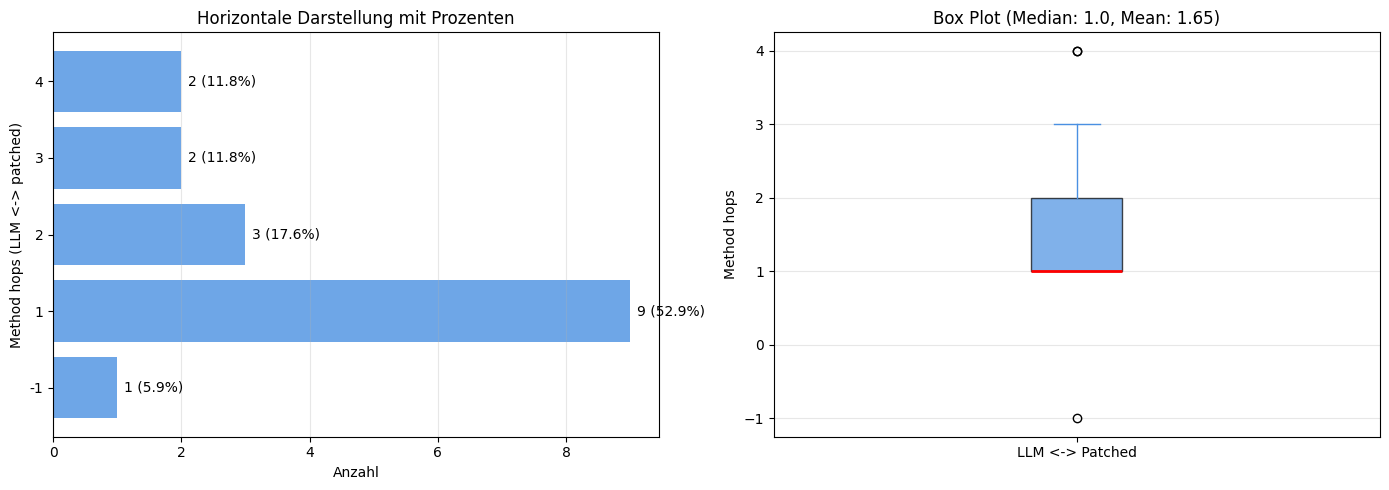

In [12]:
# Alternative Visualisierungen der LLM-Patched Distanz

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Horizontal Bar Chart mit Prozentangaben
total = sum(hops_counts.values)
axes[0].barh(hops_counts.index.astype(str), hops_counts.values, color="#4A90E2", alpha=0.8)
for idx, (hop, count) in enumerate(zip(hops_counts.index, hops_counts.values)):
    pct = count / total * 100
    axes[0].text(count + 0.1, idx, f'{count} ({pct:.1f}%)', va='center')
axes[0].set_ylabel("Method hops (LLM <-> patched)")
axes[0].set_xlabel("Anzahl")
axes[0].set_title("Horizontale Darstellung mit Prozenten")
axes[0].grid(axis='x', alpha=0.3)

# 2. Box Plot (zeigt Streuung und Median)
axes[1].boxplot(method_hops, vert=True, patch_artist=True,
                   boxprops=dict(facecolor="#4A90E2", alpha=0.7),
                   medianprops=dict(color="red", linewidth=2),
                   whiskerprops=dict(color="#4A90E2"),
                   capprops=dict(color="#4A90E2"))
axes[1].set_ylabel("Method hops")
axes[1].set_title(f"Box Plot (Median: {np.median(method_hops):.1f}, Mean: {np.mean(method_hops):.2f})")
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(['LLM <-> Patched'])

plt.tight_layout()
plt.show()

In [13]:
# Calculate correlation between Correct class / Correct method and "Method hops (Test-Patched)"

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Create 3-tuple consists of (Method hops (Test-Patched), Class correct, Method correct)
tuples_3d = []
for _, row in df_header.iterrows():
    if pd.notna(row['Method hops (Test <-> Patched)']) and pd.notna(row['Class correct']) and pd.notna(row['Method correct']):
        tuples_3d.append(
            (
                int(row['Method hops (Test <-> Patched)']),
                str(row['Class correct']).strip().upper() == "T",
                str(row['Method correct']).strip().upper() == "T",
            )
        )

# Calculate correlation for Methods hops vs Class correct and respectively Method correct

if tuples_3d:
    arr = np.array(tuples_3d, dtype=object)
    method_hops = arr[:, 0].astype(int)
    class_correct = arr[:, 1].astype(bool).astype(int)
    method_correct = arr[:, 2].astype(bool).astype(int)

    corr_class = np.corrcoef(method_hops, class_correct)[0, 1]
    corr_method = np.corrcoef(method_hops, method_correct)[0, 1]

    print(f"Correlation between 'Method hops (Test-Patched)' and 'Class correct': {corr_class:.4f}")
    print(f"Correlation between 'Method hops (Test-Patched)' and 'Method correct': {corr_method:.4f}")

Correlation between 'Method hops (Test-Patched)' and 'Class correct': -0.2363
Correlation between 'Method hops (Test-Patched)' and 'Method correct': -0.0578


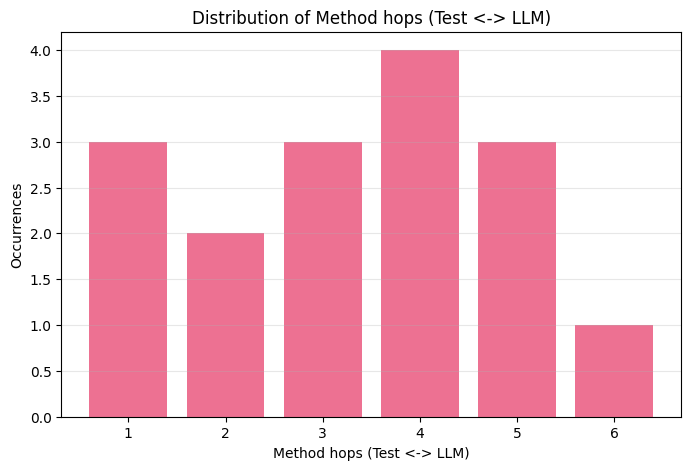

In [14]:
# Draw distribution of "Method hops (Test <-> LLM) "

import matplotlib.pyplot as plt
import pandas as pd

# Get Method hops (Test <-> LLM)
df_filtered = df_header[pd.to_numeric(df_header['Method hops (LLM <-> patched)'],errors='coerce').ne(0)]
method_hops_test_llm = (
    df_filtered['Method hops (Test <-> LLM)']
    .dropna()
    .astype(int)
    .tolist()
)

# Draw bar chart
hops_counts_test_llm = pd.Series(method_hops_test_llm).value_counts().sort_index()
plt.figure(figsize=(8, 5))
plt.bar(hops_counts_test_llm.index, hops_counts_test_llm.values, color="#E94E77", alpha=0.8)
plt.xlabel("Method hops (Test <-> LLM)")
plt.ylabel("Occurrences")
plt.title("Distribution of Method hops (Test <-> LLM)")
plt.xticks(hops_counts_test_llm.index)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Was sagt das aus? Wenn Werte 

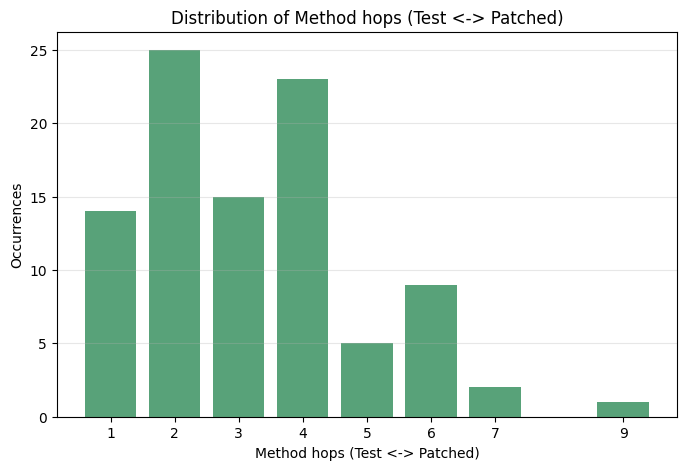

In [15]:
import pandas as pd

# Draw distribution of "Method hops (Test <-> Patched)"

import matplotlib.pyplot as plt

# Get Method hops (Test <-> Patched)
method_hops_test_patched = (
  df_header['Method hops (Test <-> Patched)']
  .dropna()
  .astype(int)
  .tolist()
)

# Draw bar chart
hops_counts_test_patched = pd.Series(method_hops_test_patched).value_counts().sort_index()
plt.figure(figsize=(8, 5))
plt.bar(hops_counts_test_patched.index, hops_counts_test_patched.values, color="#2E8B57", alpha=0.8)
plt.xlabel("Method hops (Test <-> Patched)")
plt.ylabel("Occurrences")
plt.title("Distribution of Method hops (Test <-> Patched)")
plt.xticks(hops_counts_test_patched.index)
plt.grid(axis='y', alpha=0.3)
plt.show()

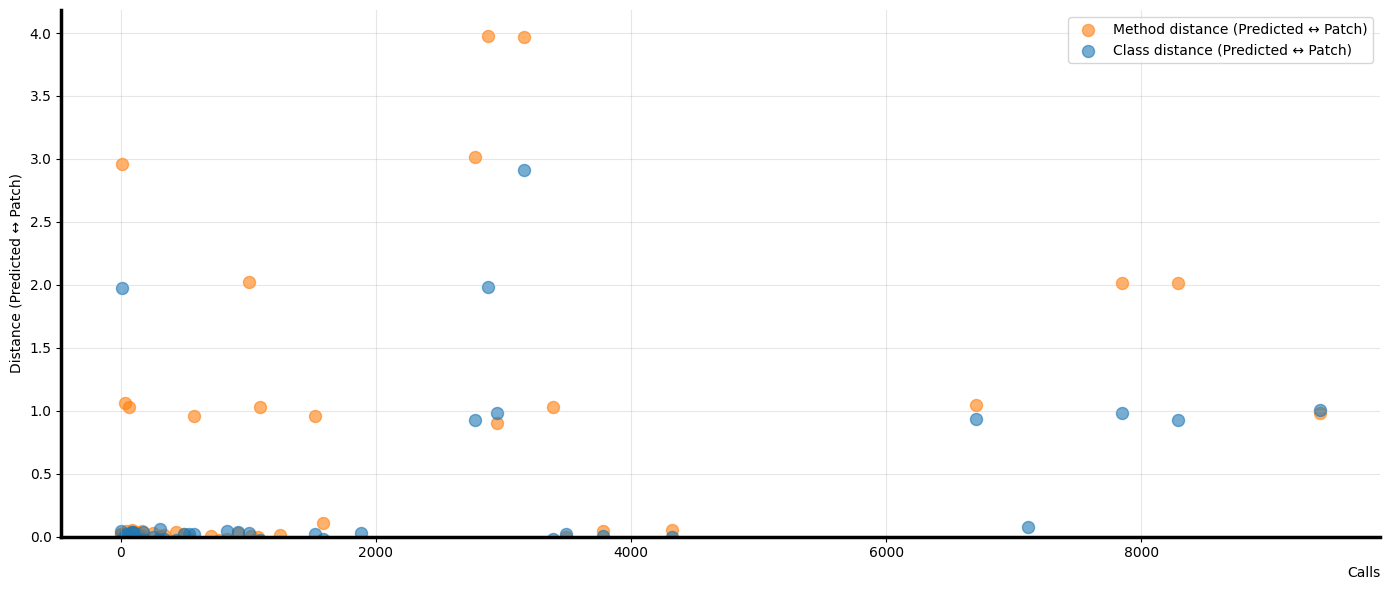

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Einfache Distanz Predicted <-> Patch (Methoden- und Klassendistanz)
df_plot = df_header.loc[
    df_header[['Calls', 'Method hops (LLM <-> patched)', 'Class Hops (LLM <-> patched)']].notna().all(axis=1)
].copy()

df_plot['Calls'] = pd.to_numeric(df_plot['Calls'], errors='coerce')
df_plot['Method hops (LLM <-> patched)'] = pd.to_numeric(df_plot['Method hops (LLM <-> patched)'], errors='coerce')
df_plot['Class Hops (LLM <-> patched)'] = pd.to_numeric(df_plot['Class Hops (LLM <-> patched)'], errors='coerce')
df_plot = df_plot.dropna(subset=['Calls', 'Method hops (LLM <-> patched)', 'Class Hops (LLM <-> patched)'])

# Negative Werte ausblenden
df_plot = df_plot[
    (df_plot['Method hops (LLM <-> patched)'] >= 0) &
    (df_plot['Class Hops (LLM <-> patched)'] >= 0)
]

fig, ax = plt.subplots(figsize=(14, 6))

rng_jitter = np.random.default_rng(seed=42)
jitter_strength = 0.05

jitter_method = rng_jitter.normal(0, jitter_strength, len(df_plot))
jitter_class  = rng_jitter.normal(0, jitter_strength, len(df_plot))

ax.scatter(df_plot['Calls'], df_plot['Method hops (LLM <-> patched)'] + jitter_method,
           color="#ff7f0e", alpha=0.6, label="Method distance (Predicted ↔ Patch)", s=75)
ax.scatter(df_plot['Calls'], df_plot['Class Hops (LLM <-> patched)'] + jitter_class,
           color="#1f77b4", alpha=0.6, label="Class distance (Predicted ↔ Patch)", s=75)

ax.set_xlabel("Calls", loc='right')
ax.set_ylabel("Distance (Predicted ↔ Patch)")
ax.set_title("")
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim(bottom=0)

ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


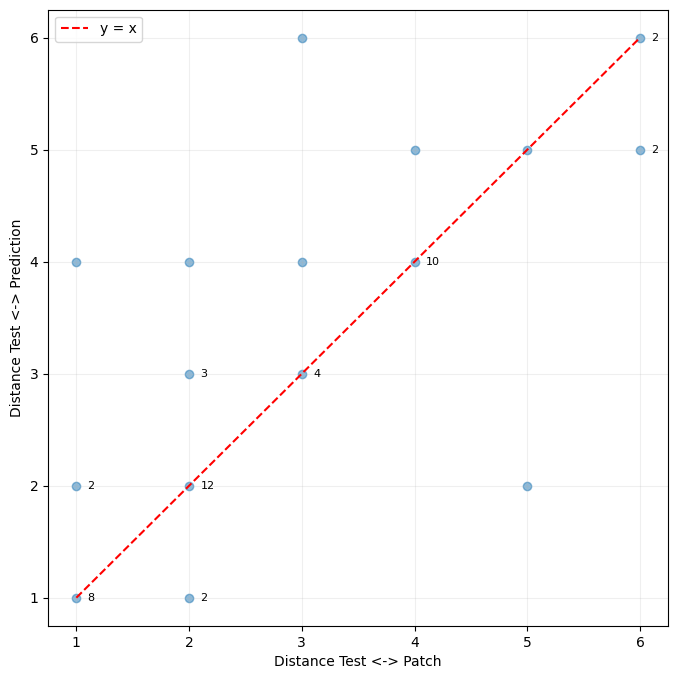

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Filter DataFrame auf vorhandene Werte
df_plot = df_header.loc[
    df_header[['Method hops (Test <-> LLM)', 'Method hops (Test <-> Patched)']].notna().all(axis=1)
].copy()

plt.figure(figsize=(8, 8))

# Punkte gruppieren und zählen wie oft (x,y) vorkommt
df_counts = df_plot.groupby(['Method hops (Test <-> Patched)', 'Method hops (Test <-> LLM)']).size().reset_index(name='count')

# Streudiagramm: Einmal pro einzigartigem Punkt
plt.scatter(df_counts['Method hops (Test <-> Patched)'], df_counts['Method hops (Test <-> LLM)'],
            color="#1f77b4", alpha=0.5)

# Linie y=x
min_val = min(df_counts['Method hops (Test <-> Patched)'].min(), df_counts['Method hops (Test <-> LLM)'].min())
max_val = max(df_counts['Method hops (Test <-> Patched)'].max(), df_counts['Method hops (Test <-> LLM)'].max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="y = x")

# Anzahl der überlappenden Punkte als Textlabel hinzufügen, nur nach rechts versetzt
for _, row in df_counts.iterrows():
    if row['count'] > 1:
        plt.text(row['Method hops (Test <-> Patched)'] + 0.1,   # kleine Verschiebung nach rechts
                 row['Method hops (Test <-> LLM)'],           # gleiche Höhe
                 str(int(row['count'])),
                 fontsize=8, ha='left', va='center', color='black')

plt.xlabel("Distance Test <-> Patch")
plt.ylabel("Distance Test <-> Prediction")
plt.title("")
plt.legend()
plt.grid(alpha=0.2)
plt.show()


Distances: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Class correct ratio: [0.83, 0.94, 0.98, 1.0, 1.0, 1.0]
Method correct ratio: [0.7, 0.87, 0.92, 0.96, 1.0, 1.0]


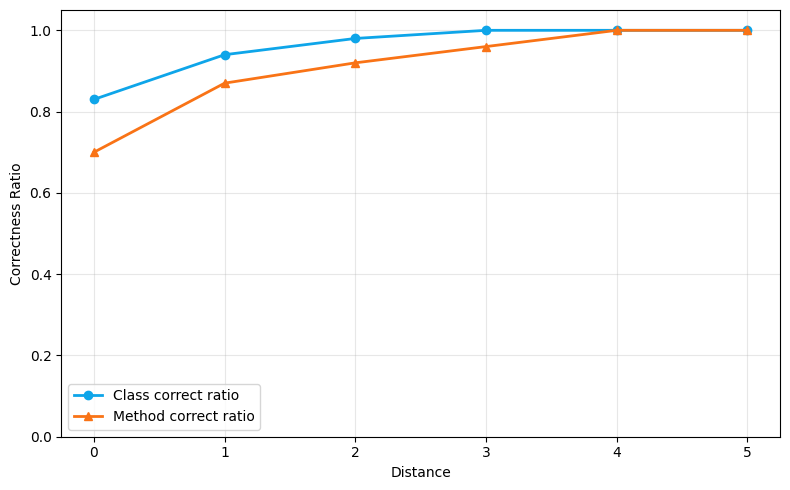

In [18]:
# Get D462:D472 as distances, G462:G472 as class correct ratio and H462:H472 as method correct ratio and plot them against each other

# Get rows 460:473 and ignore header
# Extract rows 462-472 from df_no_header
df = df_no_header.copy()

distances = df.iloc[261:267, 3].astype(float)  # Column D (index 3)
class_correct_ratio = df.iloc[261:267, 6].astype(str).str.replace(",", ".").astype(float)  # Column G (index 6)
method_correct_ratio = df.iloc[261:267, 7].astype(str).str.replace(",", ".").astype(float)  # Column H (index 7)

print("Distances:", distances.tolist())
print("Class correct ratio:", class_correct_ratio.tolist())
print("Method correct ratio:", method_correct_ratio.tolist())

# Plot it with distances on x and two categories for class correct and method correct

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(distances, class_correct_ratio, marker='o', label='Class correct ratio', color='#0ea5e9', linewidth=2)
ax.plot(distances, method_correct_ratio, marker='^', label='Method correct ratio', color='#f97316', linewidth=2)

ax.set_xlabel('Distance')
ax.set_ylabel('Correctness Ratio')
ax.set_title('')
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()

plt.show()

Calls: ['< 1,000', '< 2,000', '< 3,000', '< 4,000', '< 5,000', '< 6,000', '< 7,000', '< 8,000', '< 9,000', '< 10,000']
Class correct ratio: [0.9355, 0.9487000000000001, 0.8809999999999999, 0.8511, 0.8542000000000001, 0.8542000000000001, 0.8367, 0.8234999999999999, 0.8077, 0.7925]
Method correct ratio: [0.9031999999999999, 0.8462000000000001, 0.7857, 0.7447, 0.75, 0.75, 0.7551000000000001, 0.7646999999999999, 0.7692, 0.7547]


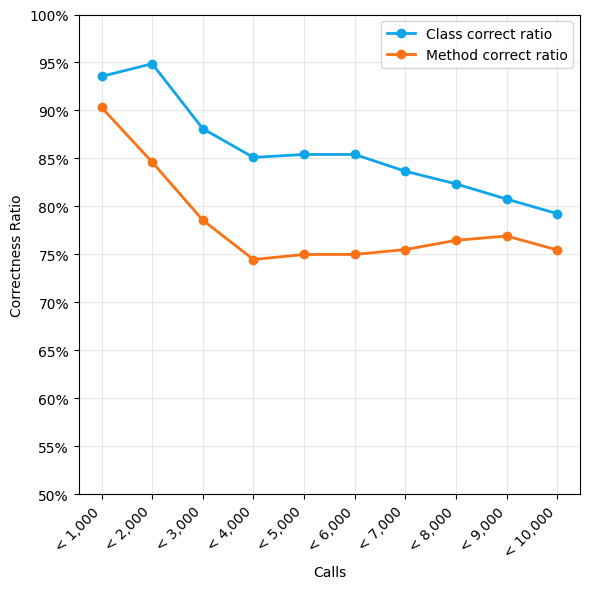

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker

# Extract rows 248-258 from df_no_header
df = df_no_header.copy()

calls = df.iloc[248:258, 3].astype(str)  # Column D (index 3)
class_correct_ratio = df.iloc[248:258, 6].astype(str)  # Column G (index 6)
method_correct_ratio = df.iloc[248:258, 8].astype(str)  # Column I (index 8)

def parse_ratio(series):
  s = series.str.strip()
  has_pct = s.str.contains("%", na=False)
  s = s.str.replace("%", "", regex=False).str.replace(",", ".", regex=False)
  vals = pd.to_numeric(s, errors="coerce")
  vals[has_pct] = vals[has_pct] / 100.0
  return vals

class_correct_ratio = parse_ratio(class_correct_ratio)
method_correct_ratio = parse_ratio(method_correct_ratio)

print("Calls:", calls.tolist())
print("Class correct ratio:", class_correct_ratio.tolist())
print("Method correct ratio:", method_correct_ratio.tolist())

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(calls, class_correct_ratio, marker='o', label='Class correct ratio', color='#0ea5e9', linewidth=2)
ax.plot(calls, method_correct_ratio, marker='o', label='Method correct ratio', color='#f97316', linewidth=2)

ax.set_xlabel('Calls')
ax.set_ylabel('Correctness Ratio')
ax.set_title('')
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim(0.5, 1)
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.05))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
x_pos = np.arange(len(calls))
for line in ax.lines:
  line.set_xdata(x_pos)

ax.set_xticks(x_pos)
ax.set_xticklabels(calls, rotation=45, ha="right")
ax.xaxis.set_major_locator(mticker.MultipleLocator(1))

plt.tight_layout()
plt.show()

# Error Rate pro Projekt

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Berechne Error Rate pro Projekt
# Error Rate = Anzahl False / Gesamt für jedes Projekt

df_error_rate = df_header[['Projekt', 'Class correct', 'Method correct']].copy()
df_error_rate['class_bool'] = df_error_rate['Class correct'].astype(str).str.strip().str.upper().eq('T').astype(int)
df_error_rate['method_bool'] = df_error_rate['Method correct'].astype(str).str.strip().str.upper().eq('T').astype(int)

# Gruppiere nach Projekt
error_rate_per_project = df_error_rate.groupby('Projekt').agg({
    'class_bool': ['sum', 'count'],
    'method_bool': ['sum', 'count']
}).reset_index()

# Flatten column names
error_rate_per_project.columns = ['Projekt', 'class_correct', 'class_total', 'method_correct', 'method_total']

# Berechne Error Rates
error_rate_per_project['class_error_rate'] = 1 - (error_rate_per_project['class_correct'] / error_rate_per_project['class_total'])
error_rate_per_project['method_error_rate'] = 1 - (error_rate_per_project['method_correct'] / error_rate_per_project['method_total'])

# Sortiere nach class error rate
error_rate_per_project = error_rate_per_project.sort_values('class_error_rate', ascending=False)

print("Error Rate pro Projekt:")
print(error_rate_per_project[['Projekt', 'class_error_rate', 'method_error_rate']])


Error Rate pro Projekt:
    Projekt  class_error_rate  method_error_rate
3       MNG          1.000000           0.800000
0  ACCUMULO          0.833333           0.833333
4       OAK          0.724138           0.758621
5    WICKET          0.628571           0.571429
2      MATH          0.500000           0.607143
1    LOG4J2          0.454545           0.545455


In [21]:
# Durchschnittliche Korrektheit pro Projekt inkl. Sample Size
import pandas as pd

proj_correctness = df_header[['Projekt', 'Class correct', 'Method correct']].copy()
proj_correctness = proj_correctness.dropna(subset=['Class correct', 'Method correct'])
proj_correctness['class_bool'] = proj_correctness['Class correct'].astype(str).str.strip().str.upper().eq('T').astype(int)
proj_correctness['method_bool'] = proj_correctness['Method correct'].astype(str).str.strip().str.upper().eq('T').astype(int)

summary = (
    proj_correctness
    .groupby('Projekt', dropna=True)
    .agg(
        sample_size=('Projekt', 'count'),
        class_correct_avg=('class_bool', 'mean'),
        method_correct_avg=('method_bool', 'mean')
    )
    .reset_index()
    .sort_values('sample_size', ascending=False)
)

# Optional: Prozentwerte
summary['class_correct_avg_pct'] = summary['class_correct_avg'] * 100
summary['method_correct_avg_pct'] = summary['method_correct_avg'] * 100

print("Durchschnittliche Korrektheit pro Projekt (mit Sample Size):")
print(
    summary[['Projekt', 'sample_size', 'class_correct_avg_pct', 'method_correct_avg_pct']]
    .to_string(index=False, formatters={
        'class_correct_avg_pct': '{:.1f}%'.format,
        'method_correct_avg_pct': '{:.1f}%'.format,
    })
)

summary

Durchschnittliche Korrektheit pro Projekt (mit Sample Size):
 Projekt  sample_size class_correct_avg_pct method_correct_avg_pct
    MATH           18                 77.8%                  61.1%
  WICKET           16                 81.2%                  93.8%
     OAK           10                 80.0%                  70.0%
  LOG4J2            7                 85.7%                  71.4%
ACCUMULO            1                100.0%                 100.0%
     MNG            1                  0.0%                 100.0%


,Projekt,sample_size,class_correct_avg,method_correct_avg,class_correct_avg_pct,method_correct_avg_pct
2,MATH,18,0.777778,0.611111,77.777778,61.111111
5,WICKET,16,0.812500,0.937500,81.250000,93.750000
4,OAK,10,0.800000,0.700000,80.000000,70.000000
1,LOG4J2,7,0.857143,0.714286,85.714286,71.428571
0,ACCUMULO,1,1.000000,1.000000,100.000000,100.000000
3,MNG,1,0.000000,1.000000,0.000000,100.000000


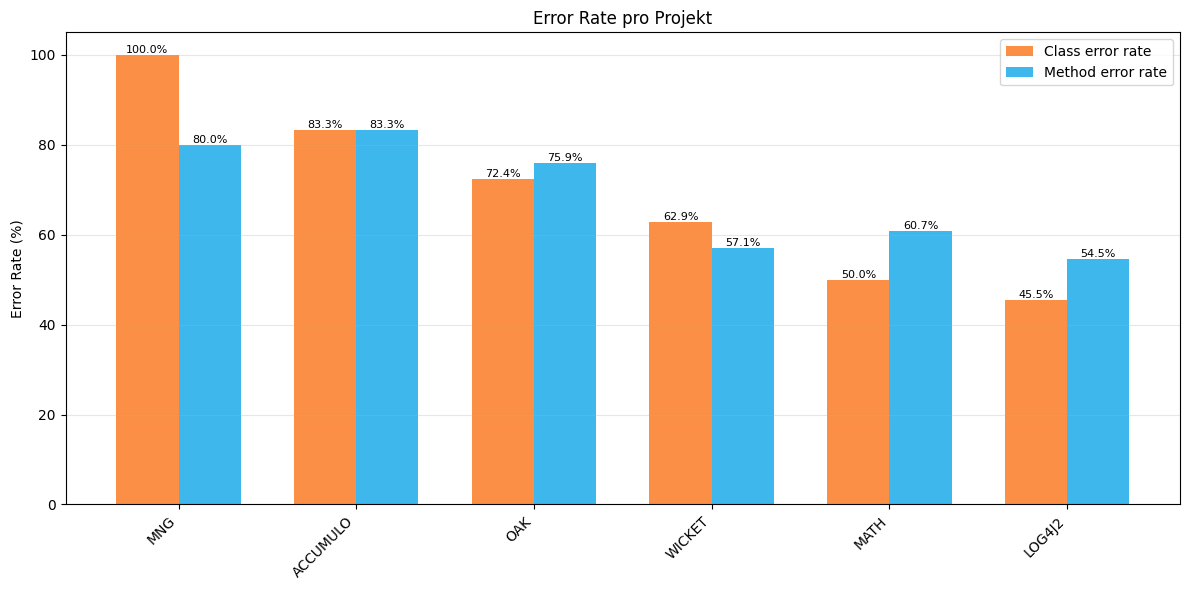

In [22]:
# Visualisiere Error Rates pro Projekt

fig, ax = plt.subplots(figsize=(12, 6))

projects = error_rate_per_project['Projekt']
x_pos = np.arange(len(projects))
width = 0.35

# Balkendiagramm
bars1 = ax.bar(x_pos - width/2, error_rate_per_project['class_error_rate'] * 100, width, label='Class error rate', color='#f97316', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, error_rate_per_project['method_error_rate'] * 100, width, label='Method error rate', color='#0ea5e9', alpha=0.8)

# Beschriftungen
ax.set_ylabel('Error Rate (%)')
ax.set_title('Error Rate pro Projekt')
ax.set_xticks(x_pos)
ax.set_xticklabels(projects, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Werte auf den Balken anzeigen
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=8)
            
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# For each "Graph" in the data, calculate the the number of vertices and edges


In [23]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd

# SPARQL endpoint
SPARQL_ENDPOINT = "http://localhost:8890/sparql"
sparql = SPARQLWrapper(SPARQL_ENDPOINT)
sparql.setReturnFormat(JSON)

# Get unique graphs from dataframe
graphs_df = df_header[['Graph']].drop_duplicates().dropna()

# Store results
results = []

for _, row in graphs_df.iterrows():
    graph_uri = row['Graph']
    
    try:
        # Query 1: Count total methods (vertices)
        query_vertices = f"""
PREFIX ex: <http://example.org/>

SELECT (COUNT(?method) AS ?totalMethods) (COUNT(DISTINCT ?method) AS ?distinctMethods)
FROM <{graph_uri}>
WHERE {{
    ?s ex:method ?method .
}}
"""
        sparql.setQuery(query_vertices)
        results_v = sparql.query().convert()
        total_methods = int(results_v['results']['bindings'][0].get('totalMethods', {}).get('value', 0))
        distinct_methods = int(results_v['results']['bindings'][0].get('distinctMethods', {}).get('value', 0))
        
        # Query 2: Count distinct classes and edges
        query_classes_edges = f"""
PREFIX ex: <http://example.org/>

SELECT 
    (COUNT(DISTINCT ?class) AS ?distinctClasses)
    (COUNT(?edge) AS ?totalEdges)
    (COUNT(DISTINCT ?edge) AS ?distinctEdges)
FROM <{graph_uri}>
WHERE {{
    {{
        ?s ex:method ?method .
        BIND(REPLACE(?method, "\\\\(.*\\\\)$", "") AS ?clean)
        BIND(REPLACE(?clean, "\\\\.[^.]+$", "") AS ?class)
    }}
    {{
        ?s ex:callee ?edge .
    }}
}}
"""
        sparql.setQuery(query_classes_edges)
        results_c = sparql.query().convert()
        distinct_classes = int(results_c['results']['bindings'][0].get('distinctClasses', {}).get('value', 0))
        total_edges = int(results_c['results']['bindings'][0].get('totalEdges', {}).get('value', 0))
        distinct_edges = int(results_c['results']['bindings'][0].get('distinctEdges', {}).get('value', 0))
        
        results.append({
            'Graph': graph_uri,
            'Total Methods': total_methods,
            'Distinct Methods': distinct_methods,
            'Distinct Classes': distinct_classes,
            'Total Edges': total_edges,
            'Distinct Edges': distinct_edges
        })
        print(f"✓ {graph_uri}: {distinct_methods} methods, {distinct_classes} classes, {distinct_edges} edges")
        
    except Exception as e:
        print(f"✗ Error querying {graph_uri}: {str(e)}")
        results.append({
            'Graph': graph_uri,
            'Error': str(e)
        })

# Create results dataframe
df_graph_stats = pd.DataFrame(results)
print("\n" + "="*80)
print("Knowledge Graph Statistics")
print("="*80)
print(df_graph_stats.to_string(index=False))

✗ Error querying urn:graph:07399ab8-e64f-463f-bff6-692c8473e19c: <urlopen error [Errno 111] Connection refused>
✗ Error querying urn:graph:421e5ecd-27cf-46b2-a2a3-6c3903bb2c4d: <urlopen error [Errno 111] Connection refused>
✗ Error querying urn:graph:a7a51d94-b1f4-4e3f-9062-4be82184fd84: <urlopen error [Errno 111] Connection refused>
✗ Error querying urn:graph:900b4183-4c95-4e1e-9310-f46facc6ec76: <urlopen error [Errno 111] Connection refused>
✗ Error querying urn:graph:eecbb166-6a3d-45d2-9fcf-49d948db394a: <urlopen error [Errno 111] Connection refused>
✗ Error querying urn:graph:effb4274-acae-4a40-ae4a-563f21271ab8: <urlopen error [Errno 111] Connection refused>
✗ Error querying urn:graph:cd1730b9-c698-4a55-90ea-f282b9d2ab5e: <urlopen error [Errno 111] Connection refused>
✗ Error querying urn:graph:16763de9-fb36-41a5-9dda-5ff27f9080de: <urlopen error [Errno 111] Connection refused>
✗ Error querying urn:graph:4f3fc323-4ed6-4ff6-bef7-1fc89b1264db: <urlopen error [Errno 111] Connection r

In [24]:
import numpy as np

# Filter: less than 10,000 calls and Consistency Check 1 = T
mask = (
    pd.to_numeric(df_header['Calls'], errors='coerce') < 10000
) & (
    df_header['Included (patch exists within calltree)'].astype(str).str.strip().str.upper() == 'TRUE'
)
df_53 = df_header[mask].copy()

# Ensure numeric types
df_53['Calls'] = pd.to_numeric(df_53['Calls'], errors='coerce')
df_53['DISTINCT methods'] = pd.to_numeric(df_53['DISTINCT methods'], errors='coerce')
df_53['DISTINCT classes'] = pd.to_numeric(df_53['DISTINCT classes'], errors='coerce')

# Drop rows with missing values in required columns
df_53 = df_53.dropna(subset=['Calls', 'DISTINCT methods', 'DISTINCT classes'])

# Derived metric: intra-components per inter-component
df_53['intra_per_inter'] = df_53['DISTINCT methods'] / df_53['DISTINCT classes']

print(f"Number of filtered experiments: {len(df_53)}")

def fmt_int(series):
    qs = np.quantile(series.astype(float), [0.0, 0.25, 0.5, 0.75, 1.0])
    return " & ".join(f"{v:.0f}" for v in qs)

def fmt_float(series):
    qs = np.quantile(series.astype(float), [0.0, 0.25, 0.5, 0.75, 1.0])
    return " & ".join(f"{v:.2f}" for v in qs)

print("\nLaTeX table rows (Min & Q0.25 & Median & Q0.75 & Max):")
print(f"Inter-components (distinct classes)    & {fmt_int(df_53['DISTINCT classes'])} \\\\")
print(f"Intra-components (distinct methods)    & {fmt_int(df_53['DISTINCT methods'])} \\\\")
print(f"Intra-components per inter-component   & {fmt_float(df_53['intra_per_inter'])} \\\\")
print(f"Call tree size (edges)                 & {fmt_int(df_53['Calls'])} \\\\")

Number of filtered experiments: 53

LaTeX table rows (Min & Q0.25 & Median & Q0.75 & Max):
Inter-components (distinct classes)    & 2 & 11 & 22 & 67 & 230 \\
Intra-components (distinct methods)    & 3 & 27 & 69 & 178 & 983 \\
Intra-components per inter-component   & 1.00 & 2.37 & 3.07 & 4.15 & 6.50 \\
Call tree size (edges)                 & 4 & 116 & 573 & 2777 & 9400 \\
